**Mini Project**
* Cats and Dogs image classification
* นางสาวเขมิกา สุนทรารักษ์ 6410210416




In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [93]:
path = "/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
      print(os.path.join(dirname, filename))

train_dir = '/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/test'

# Hyperparameters
CFG = dict(
    seed = 77,
    batch_size = 16,
    img_size = (100,100),
    epochs = 5,
    patience = 5
)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

#สร้าง data generator สำหรับภาพฝึกและทดสอบโดยใช้ flow_from_directory()
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 475 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Classes:['cats', 'dogs']


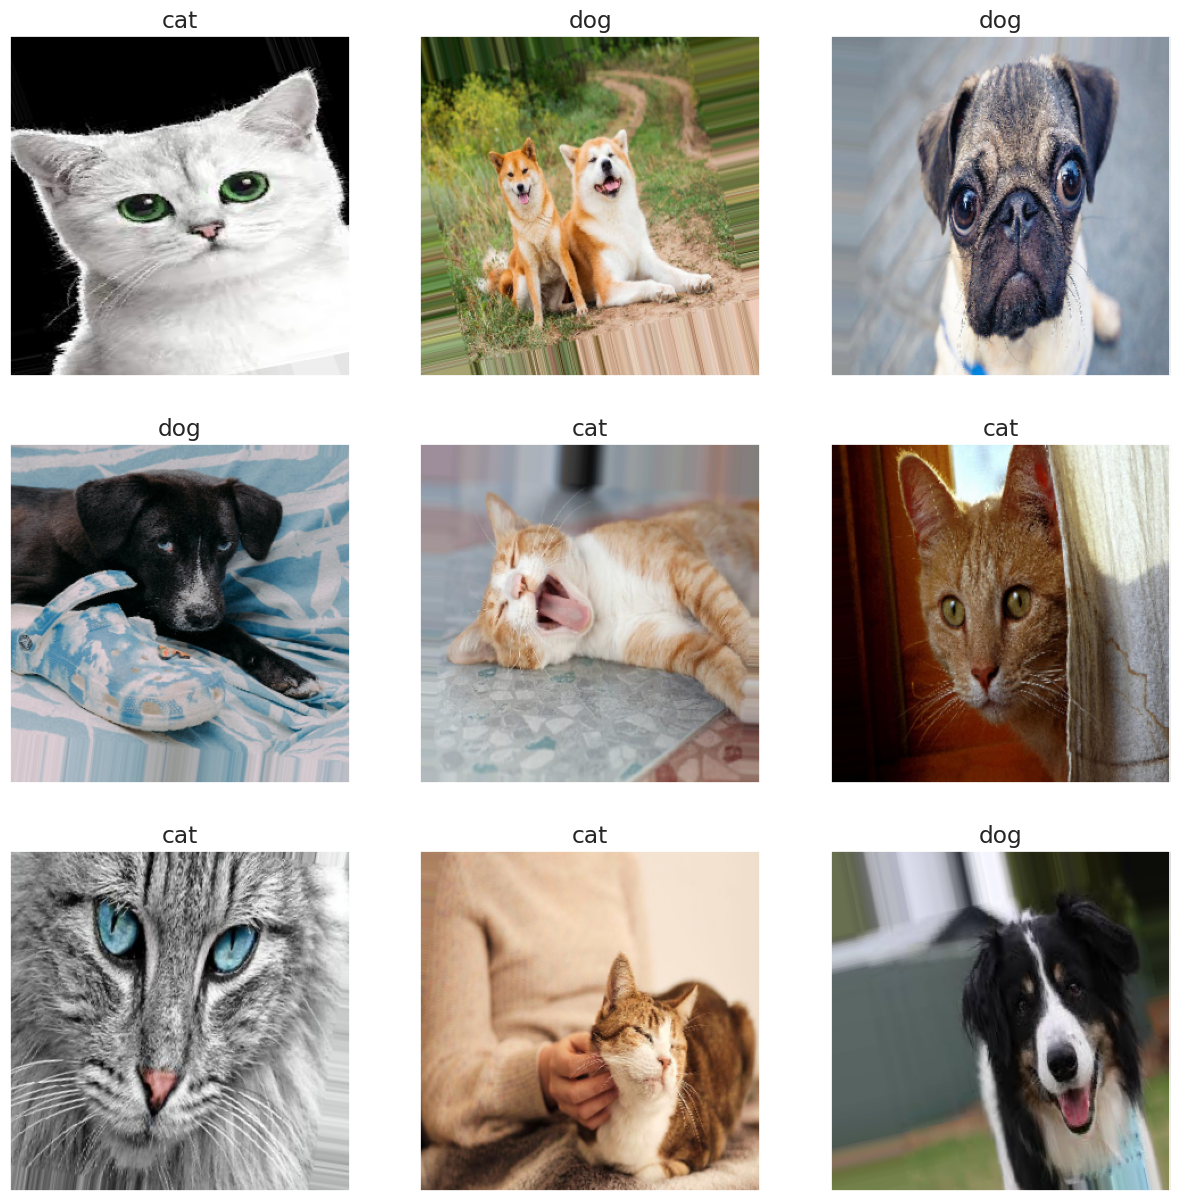

In [94]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = train_generator.next()
    imgs = (batch[0] + 1) * 127.5
    label = int(batch[1][0][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('cat' if label==1 else 'dog')
plt.show()

**CNN Model**

In [31]:
# Pre-trained deep convolutional neural network
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 2s 0us/step


In [32]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [33]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/5
29/29 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.9303
Epoch 1: val_loss improved from inf to 0.44998, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 284s 9s/step - loss: 0.4660 - accuracy: 0.9303 - val_loss: 0.4500 - val_accuracy: 0.9750
Epoch 2/5
29/29 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.9586
Epoch 2: val_loss improved from 0.44998 to 0.19649, saving model to model.h5
29/29 [==============================] - 284s 10s/step - loss: 0.3792 - accuracy: 0.9586 - val_loss: 0.1965 - val_accuracy: 0.9500
Epoch 3/5
29/29 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9739
Epoch 3: val_loss improved from 0.19649 to 0.11103, saving model to model.h5
29/29 [==============================] - 272s 9s/step - loss: 0.2149 - accuracy: 0.9739 - val_loss: 0.1110 - val_accuracy: 0.9625
Epoch 4/5
29/29 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9891
Epoch 4: val_loss did not improve from 0.11103
29/29 [==============================] - 270s 9s/step - loss: 0.0604 - accuracy: 0.9891 - val_loss: 0.1750 - val_accuracy: 0.9875

In [36]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26135873794555664
Test accuracy: 0.949999988079071


**SVM**

In [134]:
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_202.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_348.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_180.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_170.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_24.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_243.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_292.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_224.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_232.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_330.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train/cats/cat_270.jpg
/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog 

In [135]:
import os
import cv2
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

In [136]:
train = "/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train"
test = "/content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/test"
print("Training Folder path:  ",train)
print("Testing Folder path:   ",test)

Training Folder path:   /content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/train
Testing Folder path:    /content/drive/MyDrive/Colab Notebooks/344-331/Cat Dog Dataset/test


In [137]:
print(os.listdir(train))
for subfolder in os.listdir(train):
  print('subfolder name: ', subfolder)

['cats', 'dogs']
subfolder name:  cats
subfolder name:  dogs


In [138]:
def load_images(folder):
    images = []
    labels = []

    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)

        if subfolder == 'dogs':
            label = 1
        else:
            label = 0

        for imagelist in os.listdir(subfolder_path):
            if imagelist.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(subfolder_path, imagelist)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)

In [139]:
train_images, train_labels = load_images(train)
test_images, test_labels   = load_images(test)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(train_labels.shape)

(557, 64, 64, 3)
(557,)
(140, 64, 64, 3)
(557,)


In [140]:
# Reshape images
flat_train_images  = train_images.reshape(train_images.shape[0], -1)
flat_test_images   = test_images.reshape(test_images.shape[0], -1)

print(flat_train_images.shape)
print(flat_test_images.shape)

(557, 12288)
(140, 12288)


In [141]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create and train the SVM model
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=seed))
svm_model.fit(flat_train_images, train_labels)

# Make predictions on the test set
svm_predictions = svm_model.predict(flat_test_images)

# Calculate accuracy
accuracy_svm = accuracy_score(test_labels, svm_predictions)
print("Accuracy Score of SVM model:", accuracy_svm)

Accuracy Score of SVM model: 0.5714285714285714


In [142]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Define the SVM model with a pipeline for feature scaling
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=seed))

# Define a parameter grid for GridSearchCV
param_grid = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'svc__gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(flat_train_images, train_labels)

# Get the best model from the grid search
best_svm_model = grid_search.best_estimator_

# Make predictions on the test set
svm_predictions = best_svm_model.predict(flat_test_images)

# Calculate accuracy
accuracy_svm = accuracy_score(test_labels, svm_predictions)
print("Accuracy Score of SVM model:", accuracy_svm)
print("Best hyperparameters:", grid_search.best_params_)

Accuracy Score of SVM model: 0.5714285714285714
Best hyperparameters: {'svc__C': 0.001, 'svc__gamma': 'scale'}


In [144]:
import pickle

# สร้างไฟล์ .pkl เพื่อบันทึกโมเดล SVM
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm_model, file)


In [145]:
import pickle

# โหลดโมเดล SVM จากไฟล์ .pkl
with open('svm_model.pkl', 'rb') as file:
    loaded_svm_model = pickle.load(file)


**Model Evaluation**

9/9 [==============================] - 68s 7s/step


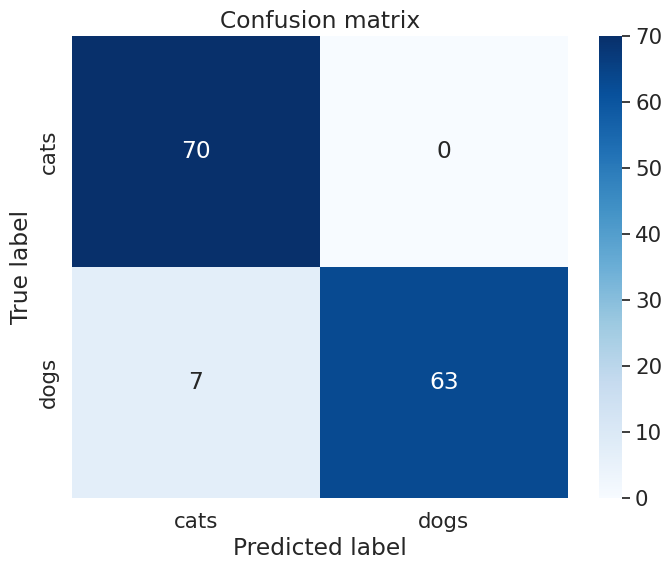

In [64]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [143]:
from sklearn.metrics import confusion_matrix

# ใช้โมเดล SVM ที่ได้สร้างขึ้นแล้ว
# แทน model ด้วยโมเดลที่คุณสร้างขึ้นแล้ว
y_pred = best_svm_model.predict(flat_test_images)

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[38 32]
 [28 42]]
